# Bird image classification
### Ariane ALIX
### 26/11/2019

In [11]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
import time
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Object Reco clean New')

Mounted at /content/drive


In [5]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## 1. Using pre-trained models


### 1.1 Counting the layers


In [6]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

layer = 0
for name, child in model.named_children():
    layer += 1
    
print('Number of layers in the net :',layer)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


Number of layers in the net : 10


### 1.2 ResNet18, all layer frozens except the last one

(Pictures resized to 256x256)
(Dataset augmented a lot)


#### 1.2.1 Look for best learning rate


Using GPU


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


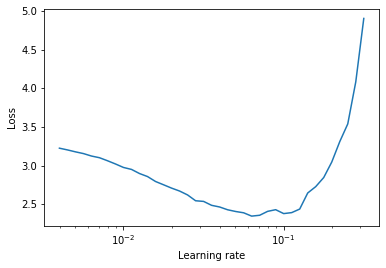

In [15]:
from torch_lr_finder import LRFinder
%run main_ResNet18_adam.py

#training dataset
training_set = torch.utils.data.DataLoader(
torch.utils.data.ConcatDataset([
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms_2)]), batch_size=args.batch_size, shuffle=True, num_workers=1)


#Model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

# We freeze the 9 first layers
layer = 0
for name, child in model.named_children():
    layer += 1
    if layer <= 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False

#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Criterion
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=training_set,val_loader=None, end_lr=100, num_iter=100)
lr_finder.plot()

In [16]:
lrs = lr_finder.history["lr"]#avoid the first small values
losses = lr_finder.history["loss"]

print('The smallest lost is :',np.min(losses),'reached for LR =',lrs[np.argmin(losses)])

The smallest lost is : 2.3480592899394224 reached for LR = 0.06309573444801932


#### 1.2.2 Train on 25 epochs with LR found
(rounded down to avoid skipping a good solution)

In [27]:
start=time.time()
%run main_ResNet18_adam.py --epochs=25 --lr=0.05 --augmented=True --experiment=experiment

for epoch in range(1, args.epochs + 1):
    train(epoch)
    validation()
    model_file = args.experiment + '/model_ResNet18_adam_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

print('CPU- Time of execution :',time.time()-start,'s')  

Using GPU
Train Epoch: 1 [0/2164 (0%)]	Loss: 3.104161
Train Epoch: 1 [640/2164 (29%)]	Loss: 37.923443
Train Epoch: 1 [1280/2164 (59%)]	Loss: 28.437366
Train Epoch: 1 [1920/2164 (88%)]	Loss: 13.897524
Training set: Accuracy: 392/2164

Validation set: Average loss: 0.1364, Accuracy: 46/103 (45%)
Saved model to experiment/model_ResNet18_adam_1.pth. You can run `python evaluate.py --model experiment/model_ResNet18_adam_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/2164 (0%)]	Loss: 11.491574
Train Epoch: 2 [640/2164 (29%)]	Loss: 3.920533
Train Epoch: 2 [1280/2164 (59%)]	Loss: 3.509014
Train Epoch: 2 [1920/2164 (88%)]	Loss: 2.089743
Training set: Accuracy: 1201/2164

Validation set: Average loss: 0.0368, Accuracy: 75/103 (73%)
Saved model to experiment/model_ResNet18_adam_2.pth. You can run `python evaluate.py --model experiment/model_ResNet18_adam_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/2164 (0%)]	Loss: 1.229681
Train Epoch: 3 [640/2164 (29%

#### 1.2.3 Train again starting from last best model (20th one)


Using GPU


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


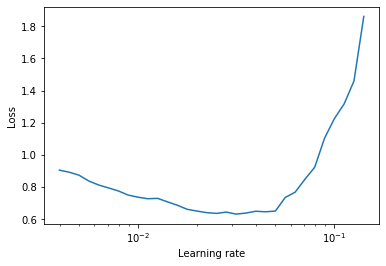

In [32]:
from torch_lr_finder import LRFinder
%run main_ResNet18_adam.py

#training dataset
training_set = torch.utils.data.DataLoader(
torch.utils.data.ConcatDataset([
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms_2)]), batch_size=args.batch_size, shuffle=True, num_workers=1)


#Model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

# We freeze the 9 first layers
layer = 0
for name, child in model.named_children():
    layer += 1
    if layer <= 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False
model.load_state_dict(torch.load('experiment/model_ResNet18_adam_20.pth'))


#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Criterion
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=training_set,val_loader=None, end_lr=100, num_iter=100)
lr_finder.plot()

In [33]:
lrs = lr_finder.history["lr"]#avoid the first small values
losses = lr_finder.history["loss"]

print('The smallest lost is :',np.min(losses),'reached for LR =',lrs[np.argmin(losses)])

The smallest lost is : 0.6299007136306135 reached for LR = 0.03162277660168379


In [34]:
start=time.time()
%run main_ResNet18_adam.py --epochs=25 --lr=0.01 --augmented=True --experiment=experiment_ResNet18_adam

for epoch in range(1, args.epochs + 1):
    train(epoch)
    validation()
    model_file = args.experiment + '/model_ResNet18_adam_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

print('CPU- Time of execution :',time.time()-start,'s')  

Using GPU
Train Epoch: 1 [0/2164 (0%)]	Loss: 0.572985
Train Epoch: 1 [640/2164 (29%)]	Loss: 0.770035
Train Epoch: 1 [1280/2164 (59%)]	Loss: 0.639734
Train Epoch: 1 [1920/2164 (88%)]	Loss: 0.474697
Training set: Accuracy: 1887/2164

Validation set: Average loss: 0.0609, Accuracy: 76/103 (74%)
Saved model to experiment_ResNet18_adam/model_ResNet18_adam_1.pth. You can run `python evaluate.py --model experiment_ResNet18_adam/model_ResNet18_adam_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/2164 (0%)]	Loss: 0.543603
Train Epoch: 2 [640/2164 (29%)]	Loss: 0.426063
Train Epoch: 2 [1280/2164 (59%)]	Loss: 0.959502
Train Epoch: 2 [1920/2164 (88%)]	Loss: 0.525908
Training set: Accuracy: 1926/2164

Validation set: Average loss: 0.0454, Accuracy: 80/103 (78%)
Saved model to experiment_ResNet18_adam/model_ResNet18_adam_2.pth. You can run `python evaluate.py --model experiment_ResNet18_adam/model_ResNet18_adam_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/21

<Figure size 432x288 with 0 Axes>

#### 1.2.4 Saving best model

In [0]:
model.load_state_dict(torch.load('experiment_ResNet18_adam/model_ResNet18_adam_15.pth'))
torch.save(model.state_dict(), 'experiment_ResNet18_adam/best_model.pth')

We saved the model with best validation error and accuracy on the training :model9 to 'experiment/model_res18_saved1'.

Before experimenting on test, we retrain it on the full labeled dataset (training + validation).

## 2. Evaluate best model

### 2.1 Retrain saved model on augmented full labeled dataset 

HBox(children=(IntProgress(value=0), HTML(value='')))

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


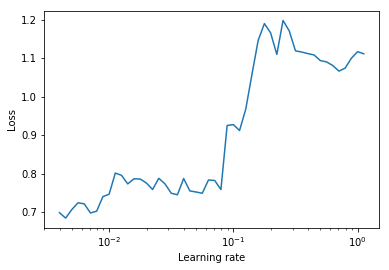

In [0]:
from torch_lr_finder import LRFinder


#training dataset
training_set = torch.utils.data.DataLoader(
torch.utils.data.ConcatDataset([
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms_2),
    datasets.ImageFolder(args.data + '/val_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/val_images',
                         transform=data_transforms_2)]), batch_size=args.batch_size, shuffle=True, num_workers=1)


#Model
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

# We freeze the 9 first layers
layer = 0
for name, child in model.named_children():
    layer += 1
    if layer <= 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False

#Loading best model found in the previous step
model.load_state_dict(torch.load('experiment_ResNet18_adam/best_model.pth'))


#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Criterion
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=training_set,val_loader=None, end_lr=100, num_iter=100)
lr_finder.plot()

In [0]:
lrs = lr_finder.history["lr"]#avoid the first small values
losses = lr_finder.history["loss"]

print('The smallest lost is :',np.min(losses),'reached for LR =',lrs[np.argmin(losses)])

The smallest lost is : 0.4582690894603729 reached for LR = 0.0012589254117941673


In [36]:
start=time.time()
%run main_ResNet18_adam.py --epochs=5  --lr=0.001 --train_all=True --experiment=experiment_ResNet18_adam_full

for epoch in range(1, args.epochs + 1):
    train(epoch)
    #validation()
    model_file = args.experiment + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

print('CPU- Time of execution :',time.time()-start,'s')  

Using GPU
Train Epoch: 1 [0/2370 (0%)]	Loss: 0.423061
Train Epoch: 1 [640/2370 (26%)]	Loss: 0.958652
Train Epoch: 1 [1280/2370 (53%)]	Loss: 0.390262
Train Epoch: 1 [1920/2370 (79%)]	Loss: 1.336121
Training set: Accuracy: 2132/2370
Saved model to experiment_ResNet18_adam_full/model_1.pth. You can run `python evaluate.py --model experiment_ResNet18_adam_full/model_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/2370 (0%)]	Loss: 0.671832
Train Epoch: 2 [640/2370 (26%)]	Loss: 0.380591
Train Epoch: 2 [1280/2370 (53%)]	Loss: 0.564214
Train Epoch: 2 [1920/2370 (79%)]	Loss: 0.471882
Training set: Accuracy: 2161/2370
Saved model to experiment_ResNet18_adam_full/model_2.pth. You can run `python evaluate.py --model experiment_ResNet18_adam_full/model_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/2370 (0%)]	Loss: 0.425433
Train Epoch: 3 [640/2370 (26%)]	Loss: 0.586542
Train Epoch: 3 [1280/2370 (53%)]	Loss: 0.440271
Train Epoch: 3 [1920/2370 (79%)]	Loss: 1.

### 2.2 Save best model trained on full dataset

In [0]:
model.load_state_dict(torch.load('experiment_ResNet18_adam_full/model_2.pth'))
torch.save(model.state_dict(), 'experiment_ResNet18_adam_full/best_model.pth')

### 2.3 Generate predictions on test set with retrained best model


In [38]:
%run evaluate_ResNet18.py --model=experiment_ResNet18_adam_full/best_model.pth --outfile=Results/ResNet18.csv

Using GPU


100%|██████████| 289/289 [01:47<00:00,  2.69it/s]

Succesfully wrote Results/ResNet18.csv, you can upload this file to the kaggle competition website
